# Arima
This file contains the ARIMA model that is used to forecast the COVID-19 cases

### Imports

In [1]:
import sys
import pandas as pd
import numpy as np
import math
import plotly.graph_objects as go
import plotly.io as pio
import plotly
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima.utils import nsdiffs

# To import the main.py file
sys.path.append('../')
from python_files import main

In [2]:
%matplotlib inline
plotly.offline.init_notebook_mode(connected=True)
pio.templates.default = 'plotly_dark'

### Data Preprocessing

In [3]:
def get_data():
    (
        confirmed_global,
        deaths_global,
        recovered_global,
        country_cases,
    ) = main.collect_data()

    recovered = recovered_global.groupby("country").sum().T
    deaths = deaths_global.groupby("country").sum().T
    confirmed = confirmed_global.groupby("country").sum().T

    deaths.index = pd.to_datetime(deaths.index, infer_datetime_format=True)
    recovered.index = pd.to_datetime(recovered.index, infer_datetime_format=True)
    confirmed.index = pd.to_datetime(confirmed.index, infer_datetime_format=True)

    return deaths, recovered, confirmed

In [4]:
def create_data_frame(dataframe, country):
    deaths, recovered, confirmed = get_data()

    if dataframe == "deaths":
        data = pd.DataFrame(
            index=deaths.index, data=deaths[country].values, columns=["Total"]
        )

    elif dataframe == "recovered":
        data = pd.DataFrame(
            index=recovered.index, data=recovered[country].values, columns=["Total"]
        )

    elif dataframe == "confirmed":
        data = pd.DataFrame(
            index=confirmed.index, data=confirmed[country].values, columns=["Total"]
        )

    data = data[(data != 0).all(1)]

    data["Date"] = data.index
    cols = [data.columns[-1]] + [col for col in data if col != data.columns[-1]]
    data = data[cols]

    return data

### Graphing

In [5]:
def plot_forecast(data, forecast):
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(x=data["Date"], y=data["Total"], mode="lines", name="Present")
    )

    fig.add_trace(
        go.Scatter(
            x=forecast.index, y=forecast["cumulative"], mode="lines", name="Predictions"
        )
    )

    fig.update_layout(
        title={
            "text": "Forecasted Results",
            "y": 0.9,
            "x": 0.5,
            "xanchor": "center",
            "yanchor": "top",
        },
        xaxis_title="Date",
        yaxis_title="Cases",
        legend_title="Legend",
        font={"family": "Arial", "size": 15},
    )

    return fig

### Model Training and Testing

In [6]:
def find_params(train_set):
    stepwise_model = auto_arima(
        train_set,
        start_p=0,
        start_q=0,
        max_p=1,
        max_q=1,
        m=7,
        start_P=0,
        start_Q=0,
        max_P=1,
        max_Q=1,
        seasonal=True,
        d=None,
        D=1,
        n_jobs=-1,
        trace=True,
        error_action="ignore",
        suppress_warnings=True,
        stepwise=True,
    )
    return stepwise_model

In [7]:
def predict_cases(stepwise_model, train, test):
    stepwise_model.fit(train)
    pred = stepwise_model.predict(n_periods=len(test))

    pred = pd.DataFrame(pred, index=test.index, columns=["Prediction"])
    pred = pred.values.flatten()

    return pred

### Error Calculation

In [8]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Forecasting

In [9]:
def future_cases(order, seasonal_order, train, test, data):
    model = SARIMAX(
        data.diff()["Total"][1:], order=order, seasonal_order=seasonal_order
    )
    result = model.fit()

    forecast = result.predict(start=len(data), end=((len(data) - 1) + 14)).rename(
        "Forecast"
    )

    forecast_cumulative = []
    start = data["Total"][-1]

    for i in forecast.values:
        if i < 0:
            i = 0
        start = start + i
        forecast_cumulative.append(start)
    forecast["cumulative"] = forecast_cumulative
    graph = plot_forecast(data, forecast)

    return forecast_cumulative, graph


### Main Function

In [10]:
def arima_predict(df_name, country):
    data = create_data_frame(df_name, country)

    train = data["Total"][: len(data) * 4 // 5].diff()[1:]
    test = data["Total"][len(data) * 4 // 5 :].diff()[1:]
    start = data["Total"][-len(test) - 1]

    model = find_params(train)
    pred = predict_cases(model, train, test)
    predictions_cumulative = []

    for i in pred:
        start = start + i
        predictions_cumulative.append(start)

    y_test_cumulative = data["Total"][-len(test) :]

    MAPE = mape(y_test_cumulative, predictions_cumulative)

    order = model.get_params()["order"]
    seasonal_order = model.get_params()["seasonal_order"]
    forecast, graph = future_cases(order, seasonal_order, train, test, data)

    return forecast, graph, MAPE

### Example

In [11]:
forecast, graph, error = arima_predict("recovered", "India")

/opt/conda/lib/python3.8/site-packages/pmdarima/arima/_validation.py:74: UserWarning:

stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=4148.726, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=4066.106, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=4022.340, Time=0.58 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=4080.686, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=4021.454, Time=1.04 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=4054.520, Time=0.51 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.51 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=4018.917, Time=1.47 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=4019.738, Time=0.94 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=4055.677, Time=0.51 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=4079.896, Time=0.10 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=4025.532, Time=1.12 sec
 ARIMA(1,1,1)(1,1,1)[7] intercept   : AIC=inf, Time=2.11 sec

Best model:  ARIMA(1,1,1)(1,1,1)[7]          
Total fit time: 9.113 seconds


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [12]:
print('Predictions for the next 2 weeks:')
for i in range(len(forecast)):
    print(int(forecast[i]))

Predictions for the next 2 weeks:
8521053
8564637
8609351
8656618
8701067
8747887
8792730
8834140
8876947
8920342
8966061
9009126
9054078
9097516


In [13]:
print(f"Allow an error of upto {error}%")

Allow an error of upto 10.809697770430057%


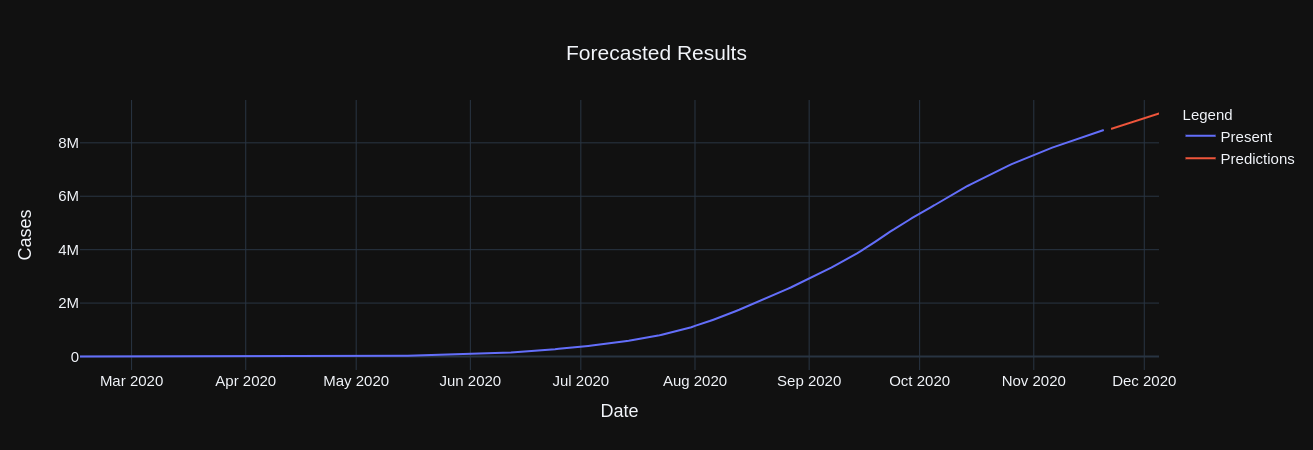

In [14]:
graph.show()